<a href="https://colab.research.google.com/github/ar040701/DeepLearningProjects/blob/main/dinov2_withsvm_rbfkernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import zipfile
import os

zip_path = "/content/Places2_simp_resit.zip"
extract_path = "/content/Places2_simp_ayush"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
from torchvision.transforms.v2 import TrivialAugmentWide

transform_train =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20),
    TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = "/content/Places2_simp_ayush/Places2_simp"

dataset =  ImageFolder(root= dataset_path, transform= transform_train)
print(len(dataset))
print(len(dataset.classes))

40000
40


In [6]:
from torch.utils.data import random_split

training_size = int(0.8 * len(dataset))
validation_size = len(dataset) - training_size

train_dataset, val_dataset = random_split(dataset, [training_size, validation_size],  generator=torch.Generator().manual_seed(40))

In [7]:
val_dataset.dataset.transform = transforms_val
train_dataLoader = DataLoader(train_dataset, batch_size=100, shuffle=False)
val_dataLoader = DataLoader(val_dataset, batch_size=100, shuffle=False)

Feature batch shape: torch.Size([100, 3, 224, 224])
Labels batch shape: torch.Size([100])


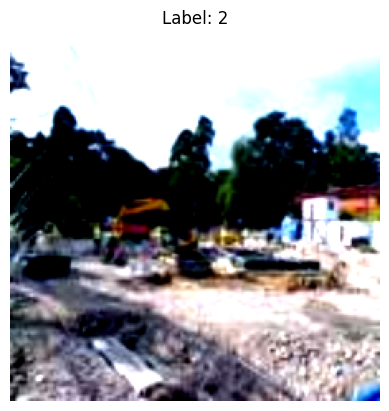

In [8]:
train_features, train_labels = next(iter(train_dataLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
img = img * 0.5 + 0.5
label = train_labels[0]
plt.imshow(img.numpy())
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [9]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
dinov2.eval()
num_classes = len(dataset.classes)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:08<00:00, 40.6MB/s]


In [10]:
writer = SummaryWriter("runs/svm_dinov2")

In [16]:
import numpy as np
def extract_features(dataloader):
  features_list=[]
  labels_list=[]
  with torch.no_grad():
    for features, labels in tqdm(dataloader):
      features = features.to(device)
      dino_features = dinov2.forward_features(features)["x_norm_clstoken"]
      features_list.append(dino_features.cpu().numpy())
      labels_list.extend(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.array(labels_list)
    return features, labels


In [17]:
X_train, y_train = extract_features(train_dataLoader)
X_validation, y_validation = extract_features(val_dataLoader)

100%|██████████| 80/80 [02:28<00:00,  1.86s/it]


In [22]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', probability=True)
svm_clf.fit(X_train, y_train)

SVC(probability=True)

In [23]:
y_pred = svm_clf.predict(X_validation)
y_prob = svm_clf.predict_proba(X_validation)

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, top_k_accuracy_score
top1_acc = accuracy_score(y_validation, y_pred) * 100
print(f"\nTop-1 Accuracy: {top1_acc:.2f}%")
top5_acc = top_k_accuracy_score(y_validation, y_prob, k=5) * 100
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


writer.add_scalar("Accuracy/Top1", top5_acc, 0)
writer.add_scalar("Accuracy/Top5", top5_acc, 0)


Top-1 Accuracy: 80.59%
Top-5 Accuracy: 97.88%


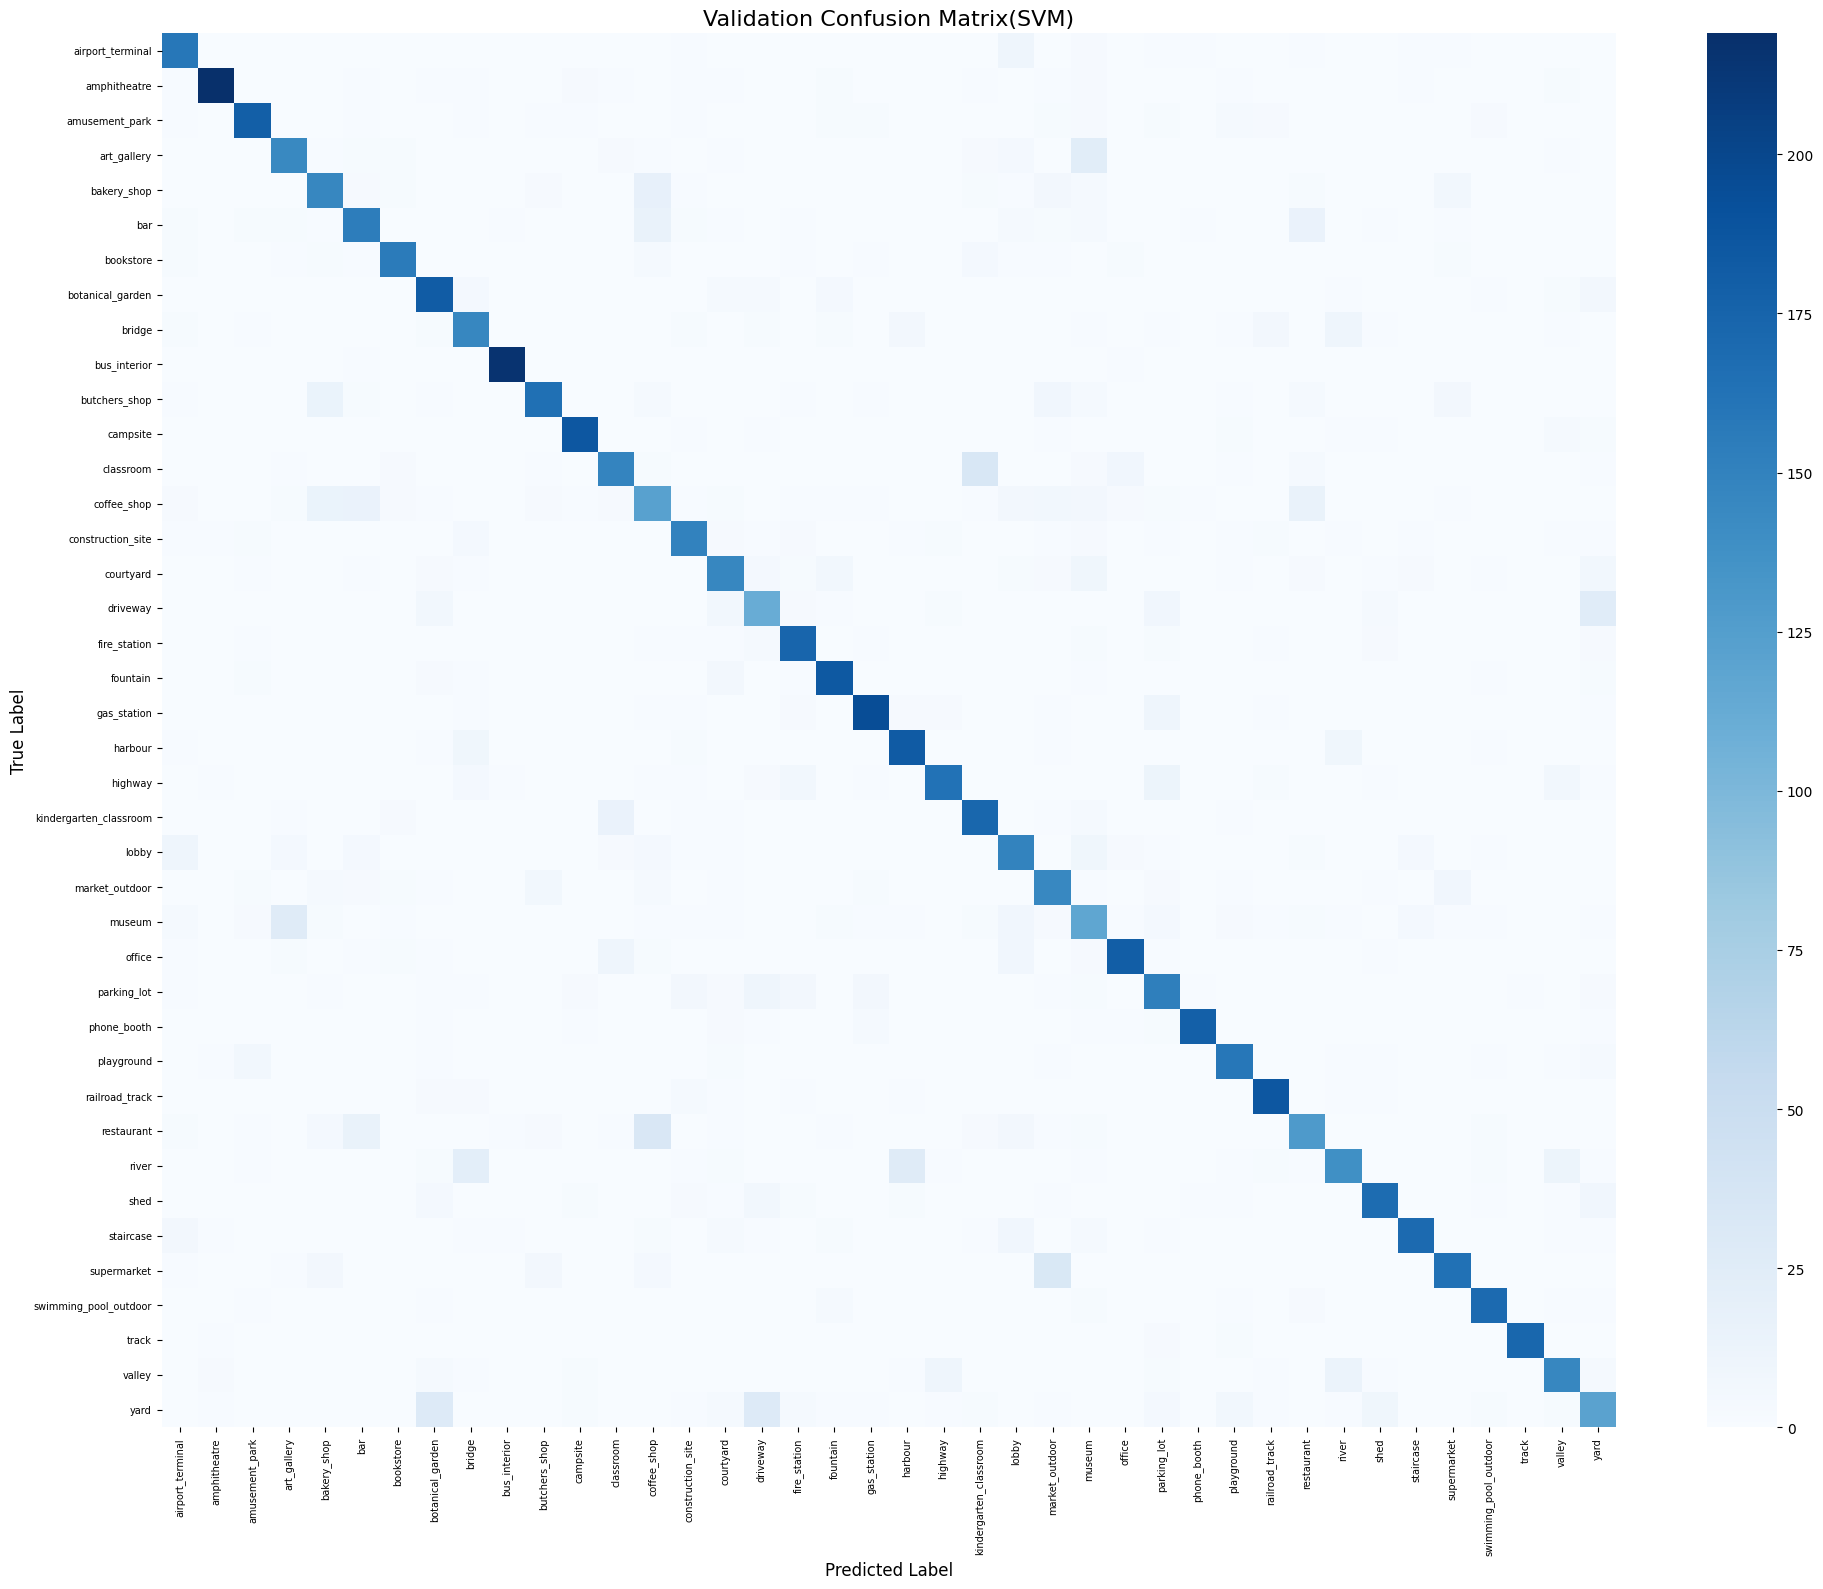

In [25]:
# Confusion matrix
cm = confusion_matrix(y_validation , y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=val_dataLoader.dataset.dataset.classes,
            yticklabels=val_dataLoader.dataset.dataset.classes)


plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.title("Validation Confusion Matrix(SVM)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig("validation_confusion_matrix_dinov2_svmkithkernelrbf.png")
plt.show()

writer.close()
